In [1]:
import sys
sys.path.insert(0, '..')
#for local import of parent dict

## Import the usual libraries
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms

from sklearn.metrics.pairwise import pairwise_distances
import scipy

import os
import numpy as np

#synth Data
from ggml.generator import get_pointcloud, create_t_triplets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#Optimal Transport
import ot

#Plotting
from ggml.plot import plot_distribution, plot_emb, hier_clustering, plot_ellipses
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

## print out the pytorch version used (1.31 at the time of this tutorial)
print(torch.__version__)

5.198227341289593e-15


/home/kuehn/anaconda3/envs/ggml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.4.0+cu118


In [2]:
## configuration to detect cuda or cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print (device)

def pairwise_mahalanobis_distance_npy(X_i,X_j=None,w=None,numThreads=32):
    # W has shape dim x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 
    if X_j is None:
        if w is None or isinstance(w,str):
            return pairwise_distances(X_i,metric=w,n_jobs=numThreads) #cdist .. ,X_j)
        else:
            if w.ndim == 2 and w.shape[0]==w.shape[1]:
                return pairwise_distances(X_i,metric="mahalanobis",n_jobs=numThreads,VI =w)    
            else:
                X_j = X_i
    #Transform poins of X_i,X_j according to W
    if w is None or isinstance(w,str):
        return scipy.spatial.distance.cdist(X_i,X_j,metric=w)
    #Assume w is cov matrix of mahalanobis distance
    elif w.ndim == 1:
        #assume cov=0, scale dims by diagonal
        w = np.diag(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)

        #proj_X_i = X_i * w[None,:]
        #proj_X_j = X_j * w[None,:]
    else: 
        w = np.transpose(w)
        proj_X_i = np.matmul(X_i,w)
        proj_X_j = np.matmul(X_j,w)
    
    return np.linalg.norm(proj_X_i[:,np.newaxis,:]  -  proj_X_j[np.newaxis,:,:],axis=-1)  

def plot_w_theta(w_theta=None,M=None,ax=None):
    if M is None:
        if isinstance(w_theta, torch.Tensor):
            W = w_theta.clone().detach().numpy()
        else:
            W = w_theta
        M = np.dot(W,np.transpose(W))
    M = M / np.linalg.norm(M)
    return plot_ellipses(M,ax=ax)

cuda:0


In [3]:
class CustomSyntheticDataset(Dataset):
    #The __init__ function is run once when instantiating the Dataset object.
    def __init__(self, *args, **kwargs):
        #Generate syntehtic data
        distributions, distributions_labels, points, point_labels, distribution_modes = get_pointcloud(*args, **kwargs)

        #Population-level 
        self.distributions = distributions
        self.distributions_labels = distributions_labels
        self.distribution_modes = distribution_modes

        #Unit-level 
        self.datapoints = points 
        self.datapoints_labels = point_labels

        #Triplets
        self.triplets = create_t_triplets(distributions,distributions_labels,**kwargs)

    def __len__(self):
        #Datapoints to train are always given as triplets
        return len(self.triplets)

    def __getitem__(self, idx):
        #Returns elements and labels of triplet at idx
        i,j,k = self.triplets[idx]
        return np.stack((self.distributions[i],self.distributions[j],self.distributions[k]),dtype="f"),np.stack((self.distributions_labels[i],self.distributions_labels[j],self.distributions_labels[k]),dtype="f")
    
    def get_raw_distributions(self):
        return self.distributions,self.distributions_labels
    
    def compute_OT_on_dists(self,ground_metric = None,w = None,legend="Side"):
        D = np.zeros((len(self.distributions),len(self.distributions)))
        for i,distribution_i in enumerate(self.distributions):
            for j,distribution_j in enumerate(self.distributions):
                if i < j:
                    if w is not None:
                        M = pairwise_mahalanobis_distance_npy(distribution_i,distribution_j,w)
                        D[i,j] = ot.emd2([],[],M)
                else:
                    D[i,j]=D[j,i]
        
        hardcoded_symbols = [i % 10 for i in range(len(self.distributions))]
        plot_emb(D,method='umap',colors=self.distributions_labels,symbols=hardcoded_symbols,legend=legend,title="UMAP",verbose=True,cmap=sns.cubehelix_palette(as_cmap=True),annotation=None,s=200)

        hier_clustering(D,self.distributions_labels, ax=None,cmap=sns.cubehelix_palette(as_cmap=False,n_colors=len(np.unique(self.distributions_labels))),dist_name="W_θ")
        return D

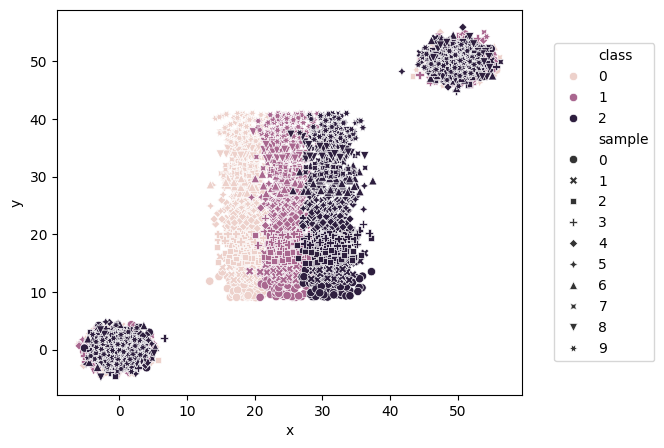

'\nfeat_dim = next(iter(train_dataset))[0].shape[-1]\n\nw = np.ones((feat_dim))\ntraining_data.compute_OT_on_dists(w = w,legend=None)\n\nw = np.zeros((feat_dim))\nw[0] = 1\ntraining_data.compute_OT_on_dists(w = w,legend=None) #euclidean\n'

In [4]:
lr = 0.02
norm = 1

n_threads = 80
iterations= 7 
plot_every_i_iterations = 24
save_every_i_iterations = 7


neighbor_t = [4] #,5,7
rank_k = [5] #,10,25,50,100,200] 

alphas = [0.1,1,10,100,1000] #,10,50,100]
lambdas = [0.1,1,10,100,1000] #,10,50,100]

n = 100
means = [5,10,15]
label =[0,1,2]
offsets = np.arange(0,30,3)+1.5

shared_means_x = [0, 40]
shared_means_y = [0, 50]

training_data = {}
train_dataset = {}

for t in neighbor_t:
        training_data[t] = CustomSyntheticDataset(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False,t=t,noise_scale=1,noise_dims=199)
        training_dataset_t = DataLoader(training_data[t] , batch_size=128, shuffle=True) 
        for a in alphas:
                for l in lambdas:
                        for k in rank_k:


                                #training_data[(a,l,t,k)] = 
                
                                train_dataset[(a,l,t,k)] = training_dataset_t #training_data[(a,l,t,k)]

#test_data = CustomSyntheticDataset(distribution_size=n, class_means = means, offsets = offsets, shared_means_x=shared_means_x, shared_means_y=shared_means_y, plot=True, varying_size=False)

#test_dataset = DataLoader(test_data, batch_size=64, shuffle=True)

#PLOTTING
'''
feat_dim = next(iter(train_dataset))[0].shape[-1]

w = np.ones((feat_dim))
training_data.compute_OT_on_dists(w = w,legend=None)

w = np.zeros((feat_dim))
w[0] = 1
training_data.compute_OT_on_dists(w = w,legend=None) #euclidean
'''



In [5]:
'''
train_features, train_labels = next(iter(train_dataset))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


trpl_distributions = train_features[0]
trpl_label = train_labels[0]


plot_distribution(trpl_distributions,trpl_label)

plt.show()
print(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")
'''

'\ntrain_features, train_labels = next(iter(train_dataset))\nprint(f"Feature batch shape: {train_features.size()}")\nprint(f"Labels batch shape: {train_labels.size()}")\n\n\ntrpl_distributions = train_features[0]\ntrpl_label = train_labels[0]\n\n\nplot_distribution(trpl_distributions,trpl_label)\n\nplt.show()\nprint(f"Example Triplet with Labels: {[l.item() for l in trpl_label]}")\n'

In [6]:
def pairwise_mahalanobis_distance(X_i,X_j,w):
    # W has shape (rank k<=dim) x dim
    # X_i, X_y have shape n x dim, m x dim
    # return Mahalanobis distance between pairs n x m 




    #Transform poins of X_i,X_j according to W
    if w.dim() == 1:
        #assume cov=0, scale dims by diagonal
        proj_X_i = X_i * w[None,:]
        proj_X_j = X_j * w[None,:]

    else: 
        w = torch.transpose(w,0,1)
        proj_X_i = torch.matmul(X_i,w)
        proj_X_j = torch.matmul(X_j,w)

    return torch.linalg.norm(proj_X_i[:,torch.newaxis,:]  -  proj_X_j[torch.newaxis,:,:],dim=-1)    




In [7]:
from tqdm import tqdm

def triplet_loss(triplet,w,alpha=torch.scalar_tensor(0.1)):
    X_i,X_j,X_k = triplet

    D_ij = pairwise_mahalanobis_distance(X_i,X_j,w)
    D_jk = pairwise_mahalanobis_distance(X_j,X_k,w)

    W_ij = ot.emd2([],[],M=D_ij,log=False,numThreads=n_threads)
    W_jk = ot.emd2([],[],M=D_jk,log=False,numThreads=n_threads)


    return torch.nn.functional.relu(W_ij -  W_jk + alpha)


In [8]:
import time

results = {}
thetas = {}
times = {}


In [ ]:
#Small example with the identity as cov matrix and a cov matrix with var 0 for dim 2 (only consider dim 1)
dim = 200 #next(iter(train_dataset))[0].shape[-1] #TODO get dim from dataset object
dia_only = False
init = "rand" #"eucl" #

#TODO move into loop for different k
#Init Theta according to set rank k
if k is None:
    k = dim

if dia_only:
    if k is not None:
        raise Warning    
    w_rand =  torch.distributions.uniform.Uniform(-1,1).sample([dim])
    w_euc = torch.ones((dim))
else:
    w_rand =  torch.distributions.uniform.Uniform(-1,1).sample([k,dim])   #torch.from_numpy(np.asarray(np.random.uniform(-1,1,(2,2)),dtype="f")) 
    w_euc = torch.diag(torch.ones((dim)))[:k,:] #TODO prob identity func in torch, yes and its .eye and not .identity!

#TODO check if save to delete (aka how paranoid do i have to be with my tensors)
w_rand.requires_grad_(requires_grad=True)
w_rand.retain_grad()
w_euc.requires_grad_(requires_grad=True) 
w_euc.retain_grad()

for a,l,t,k in train_dataset.keys():
    if (a,l,t,k) in times.keys():
        continue

    alpha = torch.scalar_tensor(a)
    lambda_ = torch.scalar_tensor(l) 


    if init == "rand":
        w_theta = w_rand.clone()
    elif init == "eucl":
        w_theta = w_euc.clone()
    w_theta.requires_grad_(requires_grad=True) 
    w_theta.retain_grad()

    #Init loss
    total_loss_random_theta = 0
    total_loss_best_theta = 0

    losses = []
    iteration_losses_total = []

    times[(a,l,t,k)] = []
    
    for i in range(1,iterations+1):
    #Iterations
        start_epoch = time.time()
        
        optimizer = torch.optim.Adam([w_theta], lr=lr)
        iteration_losses = []

        #print(type(train_dataset))
        #train_dataset_shuffled = random.sample([minibatch for minibatch in train_dataset],k=len(train_dataset))

        for triplets, labels in tqdm(train_dataset[(a,l,t,k)]):
        #Minibatches
            optimizer.zero_grad()
            loss = torch.scalar_tensor(0, requires_grad=True) #TODO doesnt actually require gradient
            for trip,labels in zip(triplets,labels):
            #Triplet

                trip.requires_grad_(requires_grad=True)
                loss = loss + triplet_loss(trip,w_theta,alpha)

                #gradient=w_rand
            #Regularization    
            loss = loss / len(triplets) + lambda_ * torch.linalg.norm(w_theta,ord=norm)  #TODO scale one by size of triplets as otherwise batchsize influences weighting of regularization
            #loss = loss + torch.linalg.norm(torch.matmul(w_theta.transpose(0,1),w_theta)-torch.eye(dim),ord=1) #penalize derivations from euclidean

            loss.backward()

            iteration_losses.append(loss.clone().detach().numpy()) #triplet_loss(t,w_rand)

            #total_loss_best_theta += triplet_loss(t,w_opt)
            optimizer.step()
            optimizer.zero_grad()
            #w_theta = w_theta - lr * w_theta.grad
            #print(f"Minibatch Loss  {np.average(iteration_losses)}")

            w_theta.grad = None
            w_theta.requires_grad_(requires_grad=True)
            w_theta.retain_grad()
        
        losses = np.concatenate((losses,iteration_losses))
        iteration_losses_total.append(np.sum(iteration_losses))
        print(f"Iteration {i} with Loss  {np.sum(iteration_losses)}")

        end_epoch = time.time() - start_epoch
        times[(a,l,t,k)].append(end_epoch)
        
        print(f"Average time for neigh {t} and Rank {k} is {np.average(times[(a,l,t,k)])}") #


        if i%plot_every_i_iterations==0 and i>0:
            print(f"Compute all OT distances after {i} iterations")
            D = training_data[(t)].compute_OT_on_dists(w = w_theta.clone().detach().numpy())    
        if i%save_every_i_iterations==0:
            thetas[(a,l,t,k)]=w_theta.clone().detach().numpy()
            np.save(f"/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/synth_200D/GGML/theta_{a}_{l}_{t}_{k}_L{norm}.npy",thetas[(a,l,t,k)])
            print(f"saved under: /home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/synth_200D/GGML/theta_{a}_{l}_{t}_{k}_L{norm}.npy")



100%|██████████| 8/8 [14:05<00:00, 105.72s/it]


Iteration 1 with Loss  107.96218872070312
Average time for neigh 4 and Rank 5 is 845.7902245521545


100%|██████████| 8/8 [10:10<00:00, 76.27s/it] 


Iteration 2 with Loss  34.200111389160156
Average time for neigh 4 and Rank 5 is 727.9923337697983


100%|██████████| 8/8 [04:10<00:00, 31.36s/it]


Iteration 3 with Loss  27.323408126831055
Average time for neigh 4 and Rank 5 is 568.9587759971619


 62%|██████▎   | 5/8 [47:10<33:40, 673.64s/it]

In [ ]:
table = np.zeros((len(rank_k),len(neighbor_t)))

for a,l,t,k in times.keys():
    #print(f"Average time for neigh {t} and Rank {k} is {np.average(times[(a,l,t,k)])}")
    table[rank_k.index(k),neighbor_t.index(t)] = np.average(times[(a,l,t,k)])

print(table)

from ggml.benchmark import knn_from_dists, plot_table, plot_1split
import pandas as pd

table_df = pd.DataFrame(data=table,index=rank_k,columns=neighbor_t).transpose()


display(table_df)
print(table_df.to_latex(index=True,
                #formatters={"name": str.upper},
                float_format="{:.1f}".format,
))

#7 & 646.02 & 671.54 & 740.73 \\

[[64.62701755]]


,5
3,64.627018


\begin{tabular}{lr}
\toprule
 & 5 \\
\midrule
3 & 64.6 \\
\bottomrule
\end{tabular}



\begin{tabular}{lrrrrr}
\toprule
 & 5 & 10 & 50 & 100 & 200 \\
\midrule
1 & 12.9 & 14.5 & 15.8 & 17.0 & 22.3 \\
3 & 130.4 & 132.5 & 143.3 & 156.0 & 195.8 \\
5 & 348.6 & 361.3 & 365.2 & 417.3 & 525.4 \\
7 & NaN & 687.6 & 789.3 & 866.7 & 1040.5 \\
9 & 1049.1 & 1119.8 & 1249.2 & 1446.2 & 1703.2 \\
\bottomrule
\end{tabular}



[[-0.9018686     -0.8667987      0.8740431     -0.31665862
  -0.29825798    -0.017327456    0.39857355     0.55550355
   0.30400637    -0.1275783     -0.03281176     0.38252324
  -0.42768687    -0.020853166    0.6105658     -0.44294918
   0.558169      -0.8018289     -0.99710035    -0.070035815
   0.62519014    -0.13847369     0.4356124      0.5862382
   0.094938375    0.03941459    -0.3165639      0.34956792
  -0.38345543    -0.20512204    -0.4681703     -0.73885
  -0.67385346    -0.016790664    0.2186817      0.7817531
   0.34055936    -0.090277426   -1.0075164     -0.54191595
  -0.9503801      0.25465286     0.9335425     -0.41629818
   0.061096087    0.33574137    -0.9866865     -0.46806234
   0.20620053     0.85549325    -0.9679487      0.13933566
  -1.1077473      0.734167      -0.15793051    -0.34462655
   0.9343213     -0.32629842    -0.7049954      0.05990691
  -0.19360301    -0.43318462     0.9069301     -0.49952123
  -0.35453635     0.5730622     -0.5571592      0.686908
  -

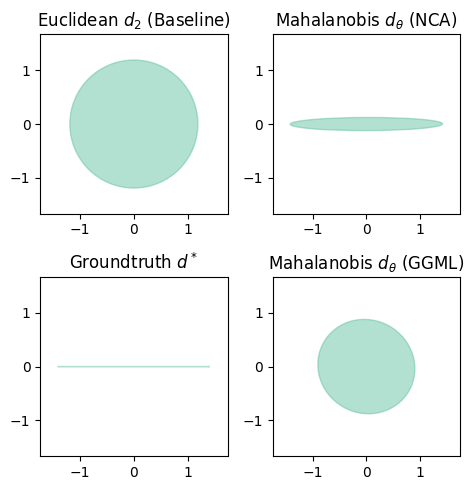

AttributeError: 'dict' object has no attribute 'compute_OT_on_dists'

<Figure size 240x240 with 0 Axes>

In [ ]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True,precision=16)
np.save("/home/kuehn/ot_metric_learning/damin-ggml/data/results/learned_parameters/synth_200D/GGML/w_theta.npy",w_theta.clone().detach().numpy())
print(w_theta.clone().detach().numpy())
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3,6))


#fig, ax = plt.subplots(figsize=(3,3))
ax = plot_w_theta(np.identity(2), ax=axs[0,0])
print(ax)
ax.set_title(r'Euclidean $d_2$ (Baseline)')
ax.get_figure().set_size_inches(4.8,5)

ax = plot_w_theta(w_theta.clone().detach().numpy(), ax=axs[1,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (GGML)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(M=np.asarray([[9.85031407, 0.02607956],
       [0.02607956, 0.07327278]]), ax=axs[0,1])
print(ax)
ax.set_title(r'Mahalanobis $d_\theta$ (NCA)')
#ax.get_figure().set_size_inches(2.4,5)


ax = plot_w_theta(np.asarray([[1,0],[0,0]]), ax=axs[1,0])
print(ax)
ax.set_title(r'Groundtruth $d^*$')
#ax.get_figure().set_size_inches(2.4,5)

plt.tight_layout()
plt.show()
from matplotlib.pyplot import figure

figure(figsize=(3, 3), dpi=80)

training_data.compute_OT_on_dists(w = w_theta.clone().detach().numpy(),legend=None)


[  0.                  2.16                4.32
   6.48                8.64               10.8
  12.96               15.120000000000001  17.28
  19.44               21.6                23.76
  25.92               28.080000000000002  30.240000000000002
  32.400000000000006  34.56               36.72
  38.88               41.040000000000006  43.2
  45.36               47.52               49.68000000000001
  51.84               54.                 56.160000000000004
  58.32000000000001   60.480000000000004  62.64
  64.80000000000001   66.96000000000001   69.12
  71.28               73.44               75.60000000000001
  77.76               79.92               82.08000000000001
  84.24000000000001   86.4                88.56
  90.72               92.88000000000001   95.04
  97.2                99.36000000000001  101.52000000000001
 103.68              105.84              108.
 110.16000000000001  112.32000000000001  114.48
 116.64000000000001  118.80000000000001  120.96000000000001
 123.1

ValueError: x and y must have same first dimension, but have shapes (100,) and (18,)

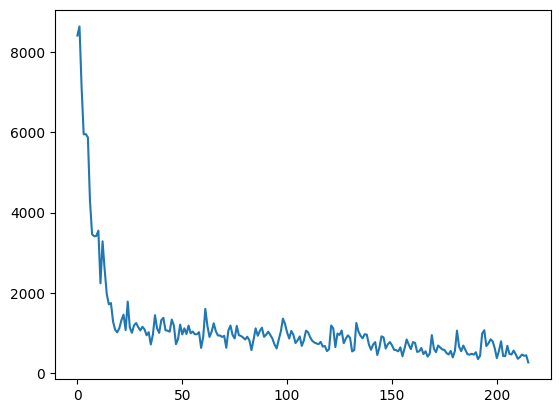

: 

: 

: 

In [ ]:
t = np.arange(len(losses))
datapoints_per_iteration = len(losses)/iterations
t2 = np.arange(0,len(losses),datapoints_per_iteration)
print(t2)
print(len(iteration_losses_total))
print(w_theta)
#fig, ax = plt.subplots()
plt.plot(t, losses, label = "loss minibatches")
plt.plot(t2, [l/datapoints_per_iteration for l in iteration_losses_total], label = "average loss iteration")
plt.legend() 




#print(total_loss_best_theta)


In [ ]:
for p1 in 

SyntaxError: invalid syntax (2993858587.py, line 1)

: 

: 

: 